In [21]:
import torch
import numpy as np
import torch.nn as nn
from sklearn.metrics import f1_score, recall_score, precision_score
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import sklearn
import json
from scipy.io import mmread, mmwrite, mminfo
import os
import dgl
from dgl.nn import GATConv


/Applications/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [132]:
corp_data = torch.load('ChinaCorp_1x_2023-06-07.pt')
corp_data.keys()


dict_keys(['Stkcd_year', 'label', 'split_idx', 'fin_ratio', 'nonfin_ratio', 'mda', 'fin_seq', 'nonfin_seq', 'mda_seq', 'node_seq', 'seq_len', 'graphs'])

In [137]:
corp_data['graphs'][2003]['path_mask'].shape

torch.Size([4111, 25])

In [97]:
mask = []
for graph in corp_data['graphs'][2003]['adj']:
    out_degrees = graph.out_degrees().int()
    in_degrees = graph.in_degrees().int()
    is_isolated = ((out_degrees + in_degrees) != 0).int().unsqueeze(1)
    mask.append(is_isolated)
mask = torch.cat(mask, dim=1)

In [143]:
import torch.nn.functional as F
# mask = torch.cat([is_isolated for _ in range(25)], dim=1)
input = torch.rand((4111, 25, 64))
weights = torch.matmul(input, input.transpose(-2, -1)).mean(2, keepdim=True)
# 将 mask 中为1的部分替换为 -inf
weights = weights.masked_fill((1-mask.unsqueeze(-1)).bool(), float('-inf'))
weights = F.softmax(weights, dim=1)
weights = weights.masked_fill((1-mask.unsqueeze(-1)).bool(), 0.0)
print(weights)
input = torch.matmul(weights.permute(0, 2, 1), input)

tensor([[[0.0000],
         [0.0000],
         [0.0000],
         ...,
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.1736],
         [0.0898],
         ...,
         [0.0000],
         [0.1045],
         [0.3473]],

        [[0.0000],
         [0.0805],
         [0.0450],
         ...,
         [0.0000],
         [0.0344],
         [0.0466]],

        ...,

        [[0.0000],
         [0.0000],
         [0.1373],
         ...,
         [0.0281],
         [0.0588],
         [0.2952]],

        [[0.7258],
         [0.0000],
         [0.0000],
         ...,
         [0.2742],
         [0.0000],
         [0.0000]],

        [[0.0000],
         [0.0000],
         [0.2126],
         ...,
         [0.0000],
         [0.0000],
         [0.7375]]])


In [79]:
attn_weights = torch.bmm(input, input.permute(0, 2, 1)).mean(2, keepdim=True)
norm_attn_weights = torch.softmax(attn_weights, dim=1)

In [6]:
with open('../meta-path/listed_firm.json', 'r') as f:
    listed_corp = json.load(f)
    

Prediction in advance?\
T0- T0+1- T0+2- T0+3- T0+4- T0+5

In [206]:
new_indices = np.array([-5, -4, -3]) - 1 
corp_data['fin_seq'][-1][new_indices]

tensor([22503, 22504, 22505])

T0-0-0-0-0-? T-4 2016-2020

In [309]:
seq_len = 3
total_len = 6
base_point = total_len
SUB_SEQ = np.array([-3, -2, -1, 0]) - 1 
if seq_len >= SUB_SEQ.shape[0]:
    SUB_SEQ = SUB_SEQ - (total_len - seq_len)
    fin_seq = corp_data['fin_seq'][-9][SUB_SEQ]
    
else: # seq_len < SUB_SEQ.shape[0]
    # 先往前回退 total_len - seq_len 个长度，再往前挪 SUB_SEQ.shape[0] - seq_len 个长度
    SUB_SEQ = SUB_SEQ - (total_len - seq_len) + (SUB_SEQ.shape[0] - seq_len)
    fin_seq = corp_data['fin_seq'][-10][SUB_SEQ]

new_seq_len = min(seq_len, SUB_SEQ.shape[0])
fin_seq, new_seq_len

(tensor([40540, 40541, 40542, 42861]), 3)

In [310]:
SUB_SEQ.tolist()

[-6, -5, -4, -3]

In [326]:
def time_span_seq_align(corp_data):
    # 对应文章中6.2的需求，将时间窗口做多种切分，如只保留t期，只保留 t-5期，只保留 t-5，t-4期
    fin_seq, nfin_seq, mda_seq, node_seq, seq_lens = corp_data['fin_seq'], corp_data['nonfin_seq'], corp_data['mda_seq'], corp_data['node_seq'], corp_data['seq_len']

    # [-5, -4, ..., -1, 0] -> [-6, -5, ..., -2, -1]
    SUB_SEQ = torch.tensor(json.loads('[-5,-4,-3,-2]')) - 1
    new_fin, new_nfin, new_mda, new_node, new_lens = [], [], [], [], []
    if SUB_SEQ.tolist()==[1]:
        # [1] 表示满长度
        new_fin, new_nfin, new_mda, new_node, new_lens = fin_seq, nfin_seq, mda_seq, node_seq, seq_lens
    elif -6 in SUB_SEQ:
        # 子序列从-5开始，early warning
        # SUB_SEQ: [-6, -5, -4, ...]
        for i in range(0, len(seq_lens)):
            new_fin.append(fin_seq[i][SUB_SEQ])
            new_nfin.append(nfin_seq[i][SUB_SEQ])
            new_mda.append(mda_seq[i][SUB_SEQ])
            new_node.append(node_seq[i][SUB_SEQ])
            new_lens.append(min(seq_lens[i], torch.tensor(SUB_SEQ.shape[0])))
        new_fin, new_nfin, new_mda, new_node, new_lens = torch.stack(new_fin), torch.stack(new_nfin), torch.stack(new_mda), torch.stack(new_node), torch.stack(new_lens)
    
    elif -1 in SUB_SEQ:
        # 子序列从0倒着回去，就近原则
        # SUB_SEQ: [..., -3, -2, -1]
        # SUB_SEQ = np.array([-3, -2, -1, 0]) - 1
        for i in range(0, len(seq_lens)):
            if seq_lens[i] >= SUB_SEQ.shape[0]:
                subseq = SUB_SEQ - (6 - seq_lens[i])
            else:  # seq_len < SUB_SEQ.shape[0]
                # 先往前回退 total_len - seq_len 个长度，再往前挪 SUB_SEQ.shape[0] - seq_len 个长度
                subseq = SUB_SEQ - (6 - seq_lens[i]) + (SUB_SEQ.shape[0] - seq_lens[i])
            new_fin.append(fin_seq[i][subseq])
            new_nfin.append(nfin_seq[i][subseq])
            new_mda.append(mda_seq[i][subseq])
            new_node.append(node_seq[i][subseq])
            new_lens.append(min(seq_lens[i], torch.tensor(SUB_SEQ.shape[0])))
        new_fin, new_nfin, new_mda, new_node, new_lens = torch.stack(new_fin), torch.stack(new_nfin), torch.stack(new_mda), torch.stack(new_node), torch.stack(new_lens)
    
    return new_fin, new_nfin, new_mda, new_node, new_lens


In [327]:
new_fin, new_nfin, new_mda, new_node, new_lens = time_span_seq_align(corp_data)


In [328]:
new_fin, corp_data['fin_seq']

(tensor([[   24,    25,    26,    27],
         [ 3699,  3700,  3701,  3702],
         [   23,    24,    25,    26],
         ...,
         [38948, 38949, 38950, 38951],
         [42047, 42048, 42861, 42861],
         [22503, 22504, 22505, 22506]]),
 tensor([[   24,    25,    26,    27,    28,    29],
         [ 3699,  3700,  3701,  3702,  3703,  3704],
         [   23,    24,    25,    26,    27,    28],
         ...,
         [38948, 38949, 38950, 38951, 38952, 38953],
         [42047, 42048, 42861, 42861, 42861, 42861],
         [22503, 22504, 22505, 22506, 22507, 42861]]))

In [161]:
new_indices = np.array([-2, -1, 0]) + 5
new_fin = []
for i in range(0, len(corp_data['seq_len'])):
    new_fin.append([corp_data['fin_seq']])



array([5, 6])

In [137]:
import scipy.sparse as sp
adj = np.array([g.adjacency_matrix(scipy_fmt="csr").toarray() for g in corp_data['graphs'][2005]['adj']]).sum(0)
g = dgl.from_scipy(sp_mat=sp.csr_matrix(adj))
g

Graph(num_nodes=4111, num_edges=23884,
      ndata_schemes={}
      edata_schemes={})

In [86]:
gs = corp_data['graphs']
# [19, 3124, 64] -> [19, 4111, 64]
kg_embs = torch.stack([gs[y]['kg_embs'] for y in gs])
kg_embs.shape

torch.Size([19, 4111, 64])

In [20]:
KGE_path = '../KGE_pytorch/source/embed/'
metapath_dir = '../meta-path/mat_by_year'
metapath_list = ['gu_qin_gu', 'gud_gud', 'gud_trans',
                 'mana_gud', 'mana_mana', 'mana_qin_gud',
                 'mana_qin_mana', 'sub_trans', 'trans_trans',
                 'trans_trans_trans']
stacked_embs = torch.stack([torch.from_numpy(mmread(os.path.join(metapath_dir, str(2003), 'metapath/{}.mtx'.format(p))).todense()) for p in metapath_list], dim = 0)
concated_embs = torch.concat([torch.from_numpy(mmread(os.path.join(metapath_dir, str(2003), 'metapath/{}.mtx'.format(p))).todense()) for p in metapath_list],dim=-1)

In [24]:
stacked_embs.shape, concated_embs.shape

(torch.Size([10, 4111, 4111]), torch.Size([4111, 41110]))

In [13]:
corp_data['graphs'][2003]['one_hot_features'][0].shape

torch.Size([4111, 4111])

In [130]:
corp_data['nonfin_ratio']

tensor([[ 14.0000,   3.0000,  13.0000,  ...,   7.0838,  18.9276,  59.9443],
        [ 13.0000,   5.0000,  15.0000,  ...,  17.8898,   8.8375,  59.9443],
        [ 14.0000,   4.0000,  10.0000,  ...,  17.8898,   9.3922,  59.9443],
        ...,
        [  9.0000,   3.0000,   4.0000,  ...,  29.6189,  18.5604, 728.6425],
        [ 11.0000,   5.0000,   5.0000,  ...,  29.6189,  18.6904, 728.6425],
        [  6.0000,   2.0000,   4.0000,  ...,  29.6189,  18.7469, 728.6425]],
       dtype=torch.float64)

In [128]:
fin_seq = corp_data['fin_seq']
nonfin_seq = corp_data['nonfin_seq']
mda_seq = corp_data['mda_seq']
node_seq = corp_data['node_seq']
seq_lens = corp_data['seq_len']

fin_seq = torch.Tensor([[fin_seq[i][seq_lens[i] - 1]] for i in range(0, len(seq_lens))])
nfin_seq = torch.Tensor([[nonfin_seq[i][seq_lens[i] - 1]] for i in range(0, len(seq_lens))])
mda_seq = torch.Tensor([[mda_seq[i][seq_lens[i] - 1]] for i in range(0, len(seq_lens))])

fin_seq.squeeze(1).shape

torch.Size([5798])

In [50]:
def score(logits, labels):
        # train 阶段
        # logits本来shape是[-1, 2]，2为类别数，现在取最大那一类的概率作为最后的预测值，转换为 [-1]
        '''_, indices = torch.max(logits, dim=1)
        prediction = indices.long().cpu().numpy()'''
        SM = nn.Sigmoid()

        prediction = SM(logits).int().cpu().numpy()
        print(prediction)
        # print(prediction)
        labels = labels.cpu().numpy()

        accuracy = (prediction == labels).sum() / len(prediction)
        prec = precision_score(labels, prediction)
        recall = recall_score(labels, prediction)
        f1 = f1_score(labels, prediction, average="binary")

        return accuracy, prec, recall, f1


In [51]:
# loss = nn.CrossEntropyLoss()
loss = nn.BCELoss()
SM = nn.Sigmoid()
input = torch.randn(100, 1, requires_grad=True)

input = torch.squeeze(input)
print(input)
target = torch.empty(100, dtype=torch.float).random_(2)

loss = loss(SM(input).float(), target)
loss.backward()
print(loss)
# input, target
print(score(input, target))


tensor([-3.3392e-01, -8.7453e-01,  1.0357e-01, -6.6221e-01, -2.3187e+00,
         2.8819e-01,  7.0682e-01, -1.2064e-01,  4.7715e-01, -5.1966e-01,
         2.7027e-02,  9.2289e-01, -1.7867e+00, -9.9185e-01,  1.0907e+00,
        -7.7620e-02, -5.3571e-01, -1.4831e+00,  1.4843e+00, -5.2957e-04,
         1.0678e+00,  2.0823e+00, -6.1205e-01,  4.5127e-01,  1.0590e+00,
        -7.4710e-01, -1.0177e+00, -1.3883e+00,  1.8640e+00,  2.7630e-01,
         7.7048e-01, -2.0646e+00, -9.4343e-01,  3.4823e-01,  8.6935e-01,
         7.6448e-01,  1.0663e+00, -1.1896e+00, -9.5708e-02, -2.2207e+00,
        -2.7400e-01, -8.3569e-01,  4.0242e-01,  2.9373e-01, -5.8267e-01,
        -1.8983e-01,  7.2284e-01, -9.6019e-01,  9.5251e-01, -1.1184e+00,
        -5.8114e-01, -1.5759e+00,  7.8176e-01, -2.0891e+00,  4.6565e-01,
        -1.2269e+00,  7.1056e-01,  6.6596e-01, -2.9449e+00, -2.1816e+00,
         9.7163e-01, -1.0568e+00,  8.4136e-01, -1.2142e+00,  1.4066e-01,
        -3.6049e-01, -1.7927e+00,  4.6245e-02,  1.4

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [10]:
def score(logits, labels):
        # train 阶段
        # logits本来shape是[-1, 2]，2为类别数，现在取最大那一类的概率作为最后的预测值，转换为 [-1]
        _, indices = torch.max(logits, dim=1)
        print(indices)
        prediction = indices.long().cpu().numpy()
        labels = labels.cpu().numpy()

        accuracy = (prediction == labels).sum() / len(prediction)
        # micro f1 和 macro f1 是多分类任务里的指标
        # micro f1 是计算出所有类别总的Precision和Recall，然后计算F1，Micro-F1则更容易受到常见类别的影响。
        # macro f1 计算出每一个类的Precison和Recall后计算F1，最后将F1平均，Macro-F1平等地看待各个类别，它的值会受到稀有类别的影响
        micro_f1 = f1_score(labels, prediction, average="micro")
        macro_f1 = f1_score(labels, prediction, average="macro")
        f1 = f1_score(labels, prediction)
        prec = precision_score(labels, prediction)
        recall = recall_score(labels, prediction)
        return accuracy, prec, recall, f1

In [12]:
input = torch.tensor([[ 0.0916, 0.2009],
        [ 0.0909, -0.2012],
        [ 0.0917, -0.2019],
        [ 0.0921, -0.2025],
        [ 0.0904, -0.1998],
        [ 0.0923, -0.2017]])
target = torch.tensor([1, 0, 1, 0, 1, 0])
score(input, target)


tensor([1, 0, 0, 0, 0, 0])


(0.6666666666666666, 1.0, 0.3333333333333333, 0.5)

In [ ]:
loss = nn.CrossEntropyLoss()
loss = loss(input, target)
loss.cpu().detach().numpy(),  loss.cpu().item(), loss.item()

In [541]:
a = torch.tensor([[1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9], [1, 2, 3], [4, 5, 6], [7, 8, 9]])
b = torch.tensor([44, 55, 66, 44, 55, 66, 44, 55, 66, 44, 55, 66])

train_loader = DataLoader(dataset=TensorDataset(a, b), batch_size=4, shuffle=True)
for i, data in enumerate(train_loader):  # 注意enumerate返回值有两个,一个是序号，一个是数据（包含训练数据和标签）
    x_data, label = data
    print(' batch:{0}\n x_data:{1}\nlabel: {2}'.format(i, x_data, label))


 batch:0
 x_data:tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9],
        [4, 5, 6]])
label: tensor([44, 55, 66, 55])
 batch:1
 x_data:tensor([[7, 8, 9],
        [7, 8, 9],
        [4, 5, 6],
        [7, 8, 9]])
label: tensor([66, 66, 55, 66])
 batch:2
 x_data:tensor([[1, 2, 3],
        [1, 2, 3],
        [4, 5, 6],
        [1, 2, 3]])
label: tensor([44, 44, 55, 44])


In [566]:
fin_ratios = pd.read_csv('../findata_for_torch.csv', encoding='gb18030')
stkcd = set(fin_ratios.Stkcd)
fin_ratios = fin_ratios.set_index(['Stkcd', 'year'])

In [568]:
(fin_ratios.loc[2,'SGEE'] - np.min(fin_ratios.loc[2,'SGEE'])) / (np.max(fin_ratios.loc[2,'SGEE']) - np.min(fin_ratios.loc[2,'SGEE']))

year
2016    0.925784
2015    0.000000
2014    0.704715
2013    0.279324
2012    0.094058
2011    0.291402
2010    1.000000
Name: SGEE, dtype: float64

In [572]:
torch.std_mean(torch.tensor(fin_ratios.loc[2,'SGEE'].values))

(tensor(0.1760, dtype=torch.float64), tensor(0.9786, dtype=torch.float64))

In [147]:
sample = torch.randn(6, 6, 12)
BN = torch.nn.BatchNorm1d(6)
BN(sample)
torch.cat([torch.tensor([]),sample]).shape

torch.Size([6, 6, 12])

In [65]:
LN = nn.LayerNorm(12)
LN(sample).shape

torch.Size([6, 6, 12])

In [154]:
json.loads('[0]')

[0]

In [67]:
torch.stack([torch.rand(19, 400, 400),torch.rand(19, 400, 400)]).shape

torch.Size([2, 19, 400, 400])

In [84]:
import torch.nn.functional as F
from dgl.nn.pytorch import GATConv
import dgl
gat = GATConv(in_feats = 64,
                    out_feats = 64,
                    num_heads = 4,
                    feat_drop = 0,
                    attn_drop = 0,
                    activation = F.elu,
                    allow_zero_in_degree = True, # 是否允许有度为0的点
)
node_emb = torch.rand(4111,64)
adj = dgl.rand_graph(4111, 600)
emb, attn_weight = gat(adj, node_emb, get_attention=True)
emb.flatten(1).shape

torch.Size([4111, 256])

In [85]:
attn_weight.mean(1).squeeze()

torch.Size([600])

In [93]:
attn_weight.shape

torch.Size([600, 4, 1])

In [89]:
src, dst = adj.edges()
adj_matrix = dgl.graph((src, dst), num_nodes=4111)
adj_matrix.edata['weight'] = attn_weight
adj_matrix = adj_matrix.adjacency_matrix().to_dense()
adj_matrix.shape

torch.Size([4111, 4111])

In [87]:
adj_matrix

Graph(num_nodes=4111, num_edges=600,
      ndata_schemes={}
      edata_schemes={'weight': Scheme(shape=(4, 1), dtype=torch.float32)})

In [74]:
adj.num_edges()

600

In [53]:
torch.cat([attn_weight, attn_weight1],dim=0).shape
torch.cat([attn_weight.shape[0], attn_weight1.shape[0]],dim=0)

TypeError: expected Tensor as element 0 in argument 0, but got int

In [59]:
attn_weight.size(0)

500

In [72]:
all_data = pd.read_csv('../train_test.csv', encoding='gb18030')
# all_data.set_index('pred_year',inplace=True)

In [71]:
all_data.loc[:,:].shape

(5730, 5)

In [79]:
all_data[all_data.pred_year==2018].index.shape

(768,)

In [53]:
from sklearn.svm import SVC
svm = SVC(kernel='linear')

In [69]:
last_year = np.array(list(map(
            lambda i: corp_data['fin_seq'][i][corp_data['seq_len'][i]-1], range(0,len(corp_data['seq_len']))
        )))
last_year.shape

(5730,)

In [25]:
subfirm = pd.read_csv('../上市公司子公司情况表/subsidiary_fullname_matched.csv', encoding='gb18030')
qinshu = pd.read_csv('../股权及亲属关系/qinshu_no_dup_person.csv', encoding='gb18030')
gaoguan = pd.read_csv('../高管关系/gaoguan_no_dup_person.csv', encoding='gb18030')
gudong = pd.read_csv('../十大股东文件/gudong_not_fin.csv', encoding='gb18030')
guanlian = pd.read_csv('../关联方交易/guanlian_no_dup_person.csv', encoding='gb18030')

subfirm = subfirm.set_index(['interval'])
qinshu = qinshu.set_index(['interval'])
gaoguan = gaoguan.set_index(['interval'])
gudong = gudong.set_index(['interval'])
guanlian = guanlian.set_index(['interval'])

with open('../meta-path/listed_firm.json', 'r') as f:
    listed_corp = json.load(f)
print('共%d家上市公司' % len(listed_corp))

共4111家上市公司


In [49]:
a = torch.ones([256, 6, 84])
b = torch.ones([256, 6, 4])
c = torch.ones([256, 6, 11])
torch.cat([a,b,c],dim=-1).shape

torch.Size([256, 6, 99])

In [59]:
logits = torch.Tensor(
        [[ -0.5630, 0.2597],
        [ 0.4858, -0.2623],
        [ 0.6105, -0.2699],
        [ 0.9770, -0.7011],
        [ 0.7892,1.1153],
        [ 1.0543, -0.7584]])
pred = torch.max(logits,dim=1)[1].long()
label = torch.Tensor([1, 0, 0, 1, 0, 0]).long()
accuracy = (pred == label).sum() / len(pred)
prec = precision_score(label.numpy(), pred.numpy())
recall = recall_score(label.numpy(), pred.numpy())
f1 = f1_score(label.numpy(), pred.numpy(), average="binary")

In [72]:
from sklearn.metrics import classification_report, roc_auc_score
t = classification_report(label.numpy(), pred.numpy(), target_names=['0', '1'], output_dict=True)
print(t)

{'0': {'precision': 0.75, 'recall': 0.75, 'f1-score': 0.75, 'support': 4}, '1': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 2}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.625, 'recall': 0.625, 'f1-score': 0.625, 'support': 6}, 'weighted avg': {'precision': 0.6666666666666666, 'recall': 0.6666666666666666, 'f1-score': 0.6666666666666666, 'support': 6}}


In [76]:
t['weighted avg']

{'precision': 0.6666666666666666,
 'recall': 0.6666666666666666,
 'f1-score': 0.6666666666666666,
 'support': 6}

In [42]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input,dim=0)
        print(logpt)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [43]:
fl = FocalLoss(gamma=2,alpha=0.25)
fl(logits, label)

tensor([[-1.9982, -2.1033],
        [-2.0754, -2.1059],
        [-1.9507, -2.1135],
        [-1.5842, -2.5447],
        [-1.7720, -0.7283],
        [-1.5069, -2.6020]])


tensor(0.6876)

In [3]:
import datetime
f'{datetime.datetime.now().date()}'

'2023-06-03'

In [402]:
input = torch.rand(4111,10,64)
# attn_coef = torch.bmm(input, input.permute(0, 2, 1))
# norm_attn_coef = torch.softmax(attn_coef, dim=2).mean(1,keepdim=True)
attn_coef = torch.bmm(input, input.permute(0, 2, 1)).mean(2,keepdim=True)
norm_attn_coef = torch.softmax(attn_coef, dim=1)

print(attn_coef.shape, norm_attn_coef.shape)
torch.bmm(norm_attn_coef.permute(0, 2, 1), input)

torch.Size([4111, 10, 1]) torch.Size([4111, 10, 1])


tensor([[[0.6037, 0.6665, 0.6617,  ..., 0.3742, 0.4596, 0.5340]],

        [[0.5163, 0.5031, 0.5674,  ..., 0.4094, 0.6511, 0.6636]],

        [[0.5258, 0.5783, 0.6351,  ..., 0.3720, 0.4360, 0.5696]],

        ...,

        [[0.3728, 0.4391, 0.7207,  ..., 0.5388, 0.5359, 0.2392]],

        [[0.4702, 0.5766, 0.4685,  ..., 0.3862, 0.3388, 0.5320]],

        [[0.4819, 0.6587, 0.8157,  ..., 0.5535, 0.7652, 0.5596]]])

In [396]:
path_attns = torch.rand((4111 * 19, 10))
path_attn = torch.ones([4111, 10])
path_attns[0 * 4111: 1 * 4111] = path_attn
path_attns

tensor([[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
        ...,
        [0.3758, 0.5035, 0.5395,  ..., 0.3450, 0.1930, 0.8766],
        [0.0957, 0.0407, 0.3123,  ..., 0.4565, 0.7414, 0.7067],
        [0.9340, 0.2167, 0.0367,  ..., 0.4882, 0.2958, 0.8125]])

In [5]:
torch.cat([torch.rand(10,5),torch.rand(10,2),torch.rand(10,1)],dim=-1).shape

torch.Size([10, 8])

In [5]:
from scipy.stats import friedmanchisquare

# 创建一个包含多个相关样本的列表
sample1 = [0.6765]
sample2 = [0.6471]
sample3 = [0.6544]

# 将样本组合成一个列表
data = [sample1, sample2, sample3]

# 执行Friedman检验
statistic, p_value = friedmanchisquare(*data)

# 输出结果
print("Friedman检验统计量为：", statistic)
print("Friedman检验p值为：", p_value)

Friedman检验统计量为： 2.0
Friedman检验p值为： 0.36787944117144245


In [75]:
from scipy.stats import ttest_rel

# 创建两个独立样本的列表
acc_1 = [0.6213,0.5993,0.6103,0.6213,0.5956]
acc_2 = [0.6912,
            0.6838,
            0.6949,
            0.6912,
            0.7279
        ]
acc_3 = [0.5846, 0.5846, 0.5846, 0.5846, 0.6434]


recall_1 = [0.6397,
            0.6176,
            0.6471,
            0.625,
            0.6691]
recall_2 = [
    0.6103,
    0.5515,
    0.5956,
    0.5441,
    0.6176,
]

# 执行独立样本的t检验
(statistic, p_value) = ttest_rel(recall_1, recall_2)

# 输出结果
print("t检验统计量为：", statistic)
print("t检验p值为：", p_value)

t检验统计量为： 6.517957827261811
t检验p值为： 0.0028605662589638887


In [85]:
from scipy.stats import wilcoxon
a = [0.5956, 0.5625, 0.5846, 0.5735, 0.5772]
b = [0.6985, 0.7022, 0.6949, 0.7022, 0.6912]

wilcoxon(a, b)

/Applications/anaconda3/lib/python3.7/site-packages/scipy/stats/morestats.py:2863: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


WilcoxonResult(statistic=0.0, pvalue=0.043114446783075355)

In [10]:
# 检查正态分布
from scipy.stats import kstest, norm
stat, p = kstest(sample2, 'norm')
alpha = 0.05
if p > alpha:
    print('数据样本服从正态分布')
else:
    print('数据样本不服从正态分布')

数据样本不服从正态分布


In [5]:
# 
from mlxtend.evaluate import paired_ttest_5x2cv
import numpy as np
model1_pred = [0.3, 0.5, 0.7, 0.9]
model2_pred = [0.2, 0.4, 0.6, 0.8]

y = [0, 1, 1, 0]
X = np.array([1, 2, 3, 4]).reshape(-1, 1)
t, p = paired_ttest_5x2cv(estimator1=model1_pred, 
                           estimator2=model2_pred, 
                           X=X, 
                           y=y, 
                           scoring='accuracy', 
                           random_seed=1)
alpha = 0.05
if p > alpha:
    print('两个模型之间没有显著差异')
else:
    print('两个模型之间有显著差异')

AttributeError: 'list' object has no attribute 'fit'

In [26]:
import re
result = re.sub(r'\t| ', '', "\t a b \t '' c")
result = re.sub(r"'",'"', result)
result

'ab""c'

In [37]:
import collections
result = collections.defaultdict(list)

In [6]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [69]:
GradientBoostingClassifier(class_weight=[0.5,0.5],)

TypeError: __init__() got an unexpected keyword argument 'class_weight'

In [65]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

# 加载数据集
iris = load_iris()
X = iris.data
y = iris.target

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

def objective(trial):
    # 定义决策树模型
    clf = DecisionTreeClassifier(
        criterion='entropy',  # 划分标准
        max_depth=trial.suggest_int('max_depth', 2, 10),  # 树的最大深度
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),  # 节点划分的最小样本数
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 5),  # 叶节点最少样本数
        max_features=trial.suggest_float('max_features', 0.1, 1.0),  # 最大特征数
        random_state=0,
    )

    # 训练模型
    clf.fit(X_train, y_train)

    # 计算模型在测试集上的准确率
    score = clf.score(X_test, y_test)

    # 返回模型准确率作为目标函数的值
    return score

# 创建study对象，指定搜索算法
study = optuna.create_study(direction='maximize')

# 启动搜索过程，指定搜索次数
study.optimize(objective, n_trials=100)

# 打印最优参数和最优分数
print(f"Best score: {study.best_value:.4f}")
print("Best parameters:")
for name, value in study.best_params.items():
    print(f"  {name}: {value}")


[I 2023-05-11 22:11:50,193] A new study created in memory with name: no-name-0e4385fa-2257-49df-8023-9aee70f2f76b
[I 2023-05-11 22:11:50,199] Trial 0 finished with value: 0.9333333333333333 and parameters: {'max_depth': 7, 'min_samples_split': 6, 'min_samples_leaf': 3, 'max_features': 0.44355328055448917}. Best is trial 0 with value: 0.9333333333333333.
[I 2023-05-11 22:11:50,202] Trial 1 finished with value: 0.9666666666666667 and parameters: {'max_depth': 4, 'min_samples_split': 6, 'min_samples_leaf': 4, 'max_features': 0.629457471759617}. Best is trial 1 with value: 0.9666666666666667.
[I 2023-05-11 22:11:50,204] Trial 2 finished with value: 0.9666666666666667 and parameters: {'max_depth': 2, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.6579060282263683}. Best is trial 1 with value: 0.9666666666666667.
[I 2023-05-11 22:11:50,207] Trial 3 finished with value: 0.9333333333333333 and parameters: {'max_depth': 10, 'min_samples_split': 9, 'min_samples_leaf': 2, 'max_f

Best score: 1.0000
Best parameters:
  max_depth: 8
  min_samples_split: 9
  min_samples_leaf: 2
  max_features: 0.8554793043850732


(1797, 64)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


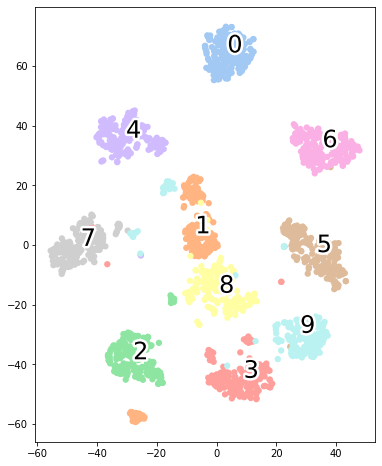

(<Figure size 576x576 with 1 Axes>,
 [Text(3.6231205, 64.51194, '0'),
  Text(-7.107086, 3.9068456, '1'),
  Text(-27.948048, -38.307602, '2'),
  Text(9.096415, -44.500793, '3'),
  Text(-30.327568, 35.932743, '4'),
  Text(33.579247, -2.3884587, '5'),
  Text(35.471077, 32.73103, '6'),
  Text(-45.513237, -0.31322768, '7'),
  Text(0.8642095, -16.00186, '8'),
  Text(28.0027, -29.439379, '9')])

In [4]:
import numpy as np

from sklearn.manifold import TSNE
# For the UCI ML handwritten digits dataset
from sklearn.datasets import load_digits

# Import matplotlib for plotting graphs ans seaborn for attractive graphics.
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import seaborn as sns

def plot(x, colors):
    # Choosing color palette
    # https://seaborn.pydata.org/generated/seaborn.color_palette.html
    palette = np.array(sns.color_palette("pastel", 10))
    # pastel, husl, and so on

    # Create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0, s=40, c=palette[colors.astype(np.int8)])
    # Add the labels for each digit.
    txts = []
    for i in range(10):
        # Position of each label.
        xtext, ytext = np.median(x[colors == i, :], axis=0)
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
        txt.set_path_effects([pe.Stroke(linewidth=5, foreground="w"), pe.Normal()])
        txts.append(txt)
    plt.show()
    # plt.savefig('./digits_tsne-pastel.png', dpi=120)
    return f, ax, txts


digits = load_digits()
print(digits.data.shape)
# There are 10 classes (0 to 9) with alomst 180 images in each class 
# The images are 8x8 and hence 64 pixels(dimensions)

# Place the arrays of data of each digit on top of each other and store in X
X = np.vstack([digits.data[digits.target==i] for i in range(10)])
# Place the arrays of data of each target digit by the side of each other continuosly and store in Y
Y = np.hstack([digits.target[digits.target==i] for i in range(10)])

# Implementing the TSNE Function - ah Scikit learn makes it so easy!
digits_final = TSNE(perplexity=30).fit_transform(X) 
# Play around with varying the parameters like perplexity, random_state to get different plots

plot(digits_final, Y)


In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X = np.load('results/base-han_5e-05_0.0_0.001_[2, 2]_256_30_[]_512_64_None_2023-05-25/output_2020.npy')


In [11]:
corp_data = torch.load('ChinaCorp_1x.pt')
corp_data['label']

tensor([1, 0, 1,  ..., 0, 1, 0])

In [12]:
corp_data.keys()

dict_keys(['label', 'split_idx', 'fin_ratio', 'nonfin_ratio', 'mda', 'fin_seq', 'nonfin_seq', 'mda_seq', 'node_seq', 'seq_len', 'graphs'])

In [71]:
test_idx = corp_data['split_idx']['test']
Y_true_test = corp_data['label'][test_idx].numpy()

normal_idxs = (Y_true_test == 0)
abnorm_idxs = (Y_true_test == 1)


/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


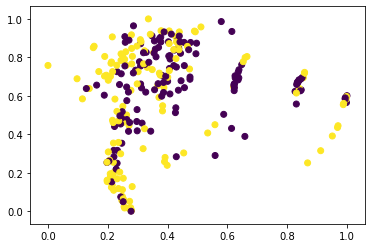

In [73]:
tsne = TSNE(n_components=2, perplexity=200, learning_rate=308.7128368980257, init='pca')


X_tsne = tsne.fit_transform(X)
x_min, x_max = X_tsne.min(0), X_tsne.max(0)
X_tsne = (X_tsne - x_min) / (x_max - x_min)

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=Y_true_test)
plt.show()

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


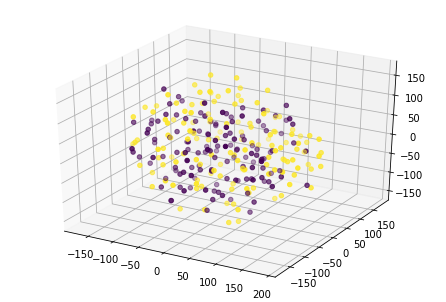

In [78]:
# 画三维图
from mpl_toolkits.mplot3d import axes3d
tsne = TSNE(n_components=3, perplexity=46, learning_rate=252, init='pca')
X_tsne = tsne.fit_transform(X)


fig = plt.figure()

ax = axes3d.Axes3D(fig)
ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=Y_true_test)
plt.show()

In [48]:
from sklearn.metrics import silhouette_score
import optuna
def objective(trial):
    # 定义参数搜索空间
    perplexity = trial.suggest_int('perplexity', 5, 50)
    learning_rate = trial.suggest_float('learning_rate', 50, 500)

    # 创建 t-SNE 模型
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate)

    # 转换数据
    X_tsne = tsne.fit_transform(X)

    # 计算聚类效果评分，这里可以根据具体需求定义自己的评分指标
    score = silhouette_score(X_tsne, Y_true_test)

    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2023-05-25 16:03:36,133] A new study created in memory with name: no-name-f7fd8019-20ef-47a9-a0b5-bc2107b47257
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
[I 2023-05-25 16:03:38,492] Trial 0 finished with value: 0.029260877519845963 and parameters: {'perplexity': 36, 'learning_rate': 276.8717681333692}. Best is trial 0 with value: 0.029260877519845963.
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
[I 2023-05-25 16:03:41,222] Trial 1 finished with value: 0.029459455981850624 and parameters: {'perplexity': 46, 'learning_rate': 401.84178505969527}. Best is trial 1 with value: 0.029459455981850624.
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning

In [52]:
best_params = study.best_params
best_score = study.best_value
best_params, best_score

({'perplexity': 46, 'learning_rate': 252.13549489045974}, 0.042205095291137695)

In [7]:
import datetime
str(datetime.datetime.now().date())

'2023-06-02'

In [16]:
attn = torch.rand((4111,25,1))
attn_sum = torch.cat([attn, attn], dim=-1)
attn_sum.shape

torch.Size([4111, 25, 2])

In [25]:
np.save('test.npy', np.stack([attn.cpu().data, attn.cpu().data]))

In [53]:
path_attn = np.load(f'results/base-han_5e-05_0.0_0.001_[2, 2]_256_30_[0]_512_64_None_2023-06-04/path_attn_2020.npy', allow_pickle=True)

In [6]:
import numpy as np
my_fr_recall = np.array([0.6677 for i in range(7)])
baseline_fr_recall = np.array([0.5647, 0.5456, 0.5971, 0.5838, 0.5985, 0.5853, 0.5529])
np.mean((my_fr_recall-baseline_fr_recall)/baseline_fr_recall)

0.1617395978252927